# TESS light curve filtering
Every lightcurve (not only TESS) will include instrumental and astrophysical signals, with the addition of atmospheric effects (seeing variations, changes in the sky's transparency...) if observations are carried out from the ground. \
In the case of TASTE data, instrumental signatures and atmospheric effects are removed through differential photometry. Stellar signals are still present, but rotational variability can be modelled as a linear or quadratic trend during the short duration of a transit [(Bentatti et al. 2019)] while short-term variability such as granulation and oscillations  (https://ui.adsabs.harvard.edu/abs/2019A%26A...630A..81B/abstract)
[(Morris et al. 2020)](https://ui.adsabs.harvard.edu/abs/2020MNRAS.493.5489M/abstract)

TESS data, on the other hand, still contains both instrumental and astrophysical signatures (in the case of SAP data) or just astrophysical ones (in the case of PDCSAP). When several weeks of continuous observations are available, several  approaches can be implemented:
1) Selection of each transit and independent modelling of the out-transit part around each transit.
2) Modelling of the astrophysical noise through a physically-justified model.
3) Empirical removal of the instrumental and astrophysical signals, regardless of their origins, through an automatic *filtering* algorithm.

The first solution becomes quickly impractical,  as each sector may contain many transits, and the target may have been observed for several sectors. The second solution requires a deep knowledge of the most advanced statistical tools to deal with correlated noise, which is beyond the scope of this course. Fortunately for us, the third approach is already implemented in a package called `wotan` ([Hippke et al. 2019](https://ui.adsabs.harvard.edu/abs/2019AJ....158..143H/abstract), [GitHub page and documentation](https://github.com/hippke/wotan)), which provide an easy-to-use interface to test several filtering algorithms.

Let's import the usual packages and then import `wotan` following the prescriptions in the documentation. 

In [1]:
import numpy as np
import pickle 
import matplotlib.pyplot as plt 
from astropy.io import fits 
%matplotlib widget

In [2]:
from wotan import flatten 

We need to import the TESS data we have to flatten. Remember to repeat the operation for every TESS sector you want to analyze.

In this example, I will perform the filtering on both the SAP and PDCSAP light curves, and compare the results of the different algorithms.


In [3]:
time = pickle.load(open('hatp44_TESS_sector023_time.p', 'rb'))
sap_flux = pickle.load(open('hatp44_TESS_sector023_sap_flux.p','rb'))
sap_flux_error = pickle.load(open('hatp44_TESS_sector023_sap_flux_error.p','rb'))

pdcsap_flux = pickle.load(open('hatp44_TESS_sector023_pdcsap_flux.p','rb'))
pdcsap_flux_error = pickle.load(open('hatp44_TESS_sector023_pdcsap_flux_error.p','rb'))

From the TESS ExoFOP website, we retrieve the orbital period, the central time of transit, and the transit duration (converted in days) of our planet. We will need these values soon. 

In [4]:
Transit_time = 2459688.443452
Period = 4.3011975
Transit_duration = 3.1/24. 


We perform a first test using the example provided in the documentation, using the *Huber spline*:

In [5]:
sap_flatten_flux, sap_flatten_model = flatten(
    time,
    sap_flux,
    method='hspline',
    window_length=0.5, 
    break_tolerance=0.5, 
    return_trend = True
)

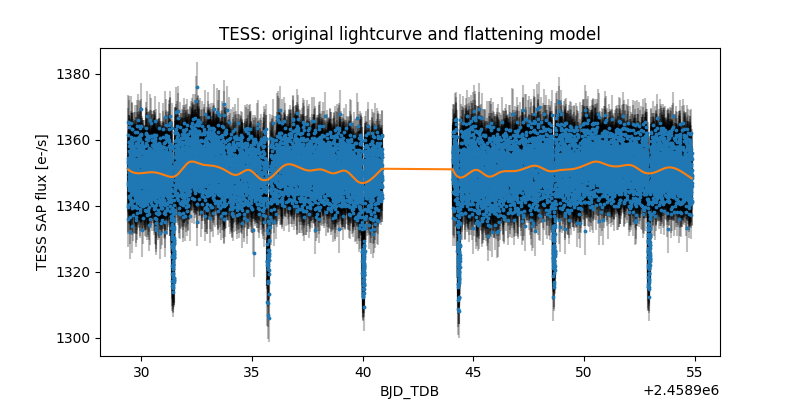

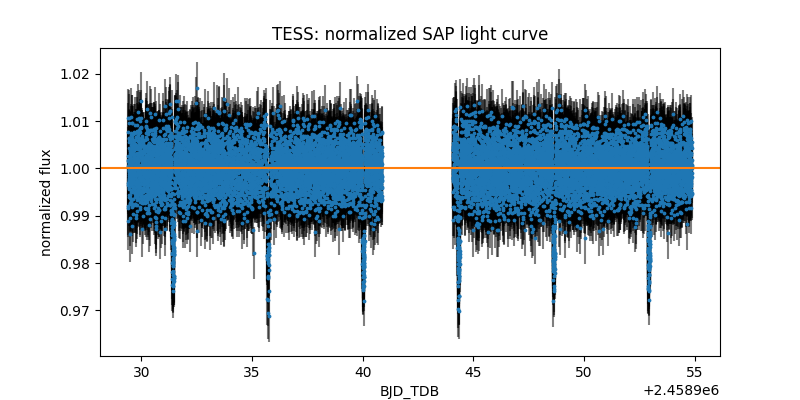

In [6]:
plt.figure(figsize=(8,4))
plt.title('TESS: original lightcurve and flattening model')
plt.scatter(time, sap_flux, c='C0', s=3)
plt.errorbar(time, sap_flux, yerr=sap_flux_error, ecolor='k', fmt=' ', alpha=0.25, zorder=-1)
plt.plot(time, sap_flatten_model, c='C1', zorder=10)
plt.xlabel('BJD_TDB')
plt.ylabel('TESS SAP flux [e-/s]')
plt.show()

plt.figure(figsize=(8,4))
plt.title('TESS: normalized SAP light curve')
plt.scatter(time, sap_flatten_flux, c='C0', s=3)
plt.errorbar(time, sap_flatten_flux, yerr=sap_flux_error/sap_flatten_model, 
             ecolor='k', fmt=' ', alpha=0.5, zorder=-1)
plt.xlabel('BJD_TDB')
plt.ylabel('normalized flux')
plt.axhline(1.000, c='C1')
plt.show()

Let's focus our attention on the results of the filtering algorithm near the transits. To better visualize the results, we can *fold* the transit around the central time of transits, knowing that the same signal is supposed to repeat after every orbital period. After folding the transit, we can focus on the small portion of time around the transit rather than display the entire orbital period.

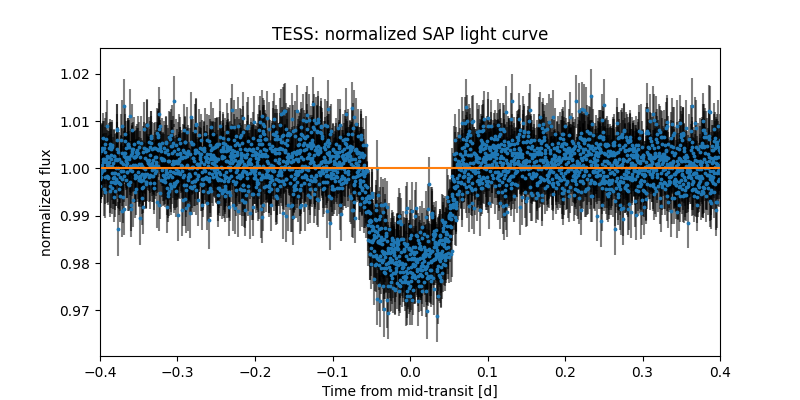

In [7]:
phase_folded_time = (time-Transit_time - Period/2)%Period - Period/2

plt.figure(figsize=(8,4))
plt.title('TESS: normalized SAP light curve')
plt.scatter(phase_folded_time, sap_flatten_flux, c='C0', s=3)
plt.errorbar(phase_folded_time, sap_flatten_flux, yerr=sap_flux_error/sap_flatten_model, 
             ecolor='k', fmt=' ', alpha=0.5, zorder=-1)
plt.xlabel('Time from mid-transit [d]')
plt.ylabel('normalized flux')
plt.xlim(-0.4, 0.4)
plt.axhline(1.000, c='C1')
plt.show()

We can see that the part of the light curve just before and after the transit is not centred around unity as it should be. The reason is that the filtering algorithm still includes some points belonging to the transit when computing the model, despite the best efforts to avoid this situation (see the code documentation and the paper for more details). To address this issue, we can compute the filtering model by excluding the points affected by the transit, as shown in this [jupyter notebook of the documentation](https://github.com/hippke/wotan/blob/master/examples/transit%20mask.ipynb). 

The only precaution we need to take is to increase the duration of the transit time taken from the ExoFOP archive, to ensure that all transit points are excluded from the computation of the filtering model. This selection is only used for the filtering step, so excluding some out-transit points from the analysis is entirely safe. Indeed, it is better to exclude some out-transit points that include in-transit points in the filtering process.

In [8]:

from wotan import transit_mask
mask = transit_mask(
    time=time,
    period = Period,
    duration = Transit_duration*1.5,
    T0=Transit_time 
)

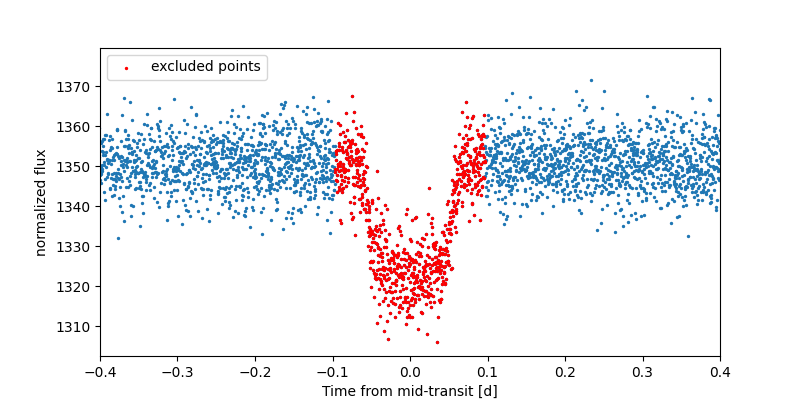

In [9]:
plt.figure(figsize=(8,4))
plt.scatter(phase_folded_time, sap_flux, s=2)
plt.scatter(phase_folded_time[mask], sap_flux[mask], c='r', zorder=1, s=2, label='excluded points')
plt.xlabel('Time from mid-transit [d]')
plt.ylabel('normalized flux')
plt.xlim(-0.4, 0.4)
plt.legend()
plt.show() 

As shown in the documentation, we can now recompute the flattening model, including the mask selection, directly as an algorithm argument.

In [10]:
sap_masked_flatten_flux, sap_masked_flatten_model = flatten(
    time,
    sap_flux,
    method='hspline',
    window_length=0.5, 
    break_tolerance=0.5, 
    return_trend = True,
    mask = mask,
)

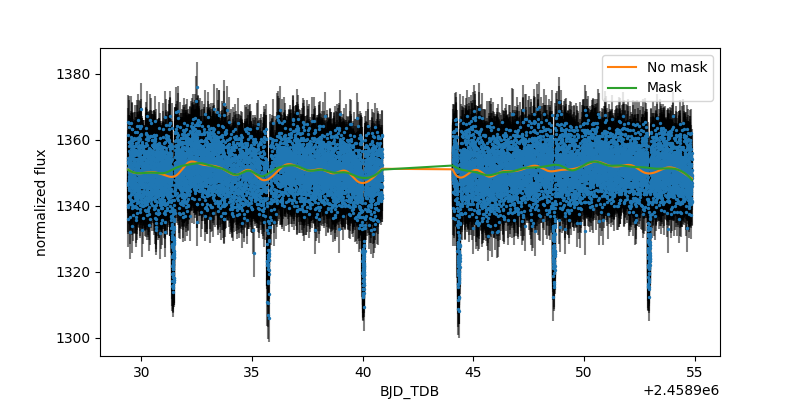

In [13]:
plt.figure(figsize=(8,4))
plt.scatter(time, sap_flux, c='C0', s=2)
plt.errorbar(time, sap_flux, yerr=sap_flux_error, ecolor='k', fmt=' ', alpha=0.5, zorder=-1)
plt.plot(time, sap_flatten_model, c='C1', zorder=10, label='No mask')
plt.plot(time, sap_masked_flatten_model, c='C2', zorder=11, label='Mask')
plt.xlabel('BJD_TDB')
plt.ylabel('normalized flux')
plt.legend()
plt.show()

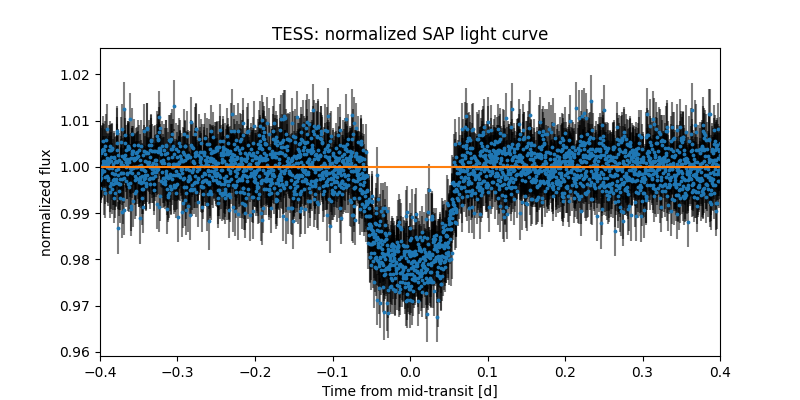

In [14]:
plt.figure(figsize=(8,4))
plt.title('TESS: normalized SAP light curve')
plt.scatter(phase_folded_time, sap_masked_flatten_flux, c='C0', s=3)
plt.errorbar(phase_folded_time, sap_masked_flatten_flux, yerr=sap_flux_error/sap_flatten_model, 
             ecolor='k', fmt=' ', alpha=0.5, zorder=-1)
plt.xlabel('Time from mid-transit [d]')
plt.ylabel('normalized flux')
plt.xlim(-0.4, 0.4)
plt.axhline(1.000, c='C1')
plt.show()

When analyzing the TASTE dataset, we determined the best parameters for the aperture photometry and the reference stars by computing the standard deviation of the out-transit part of the normalized light curve. We can use the same criterion here to determine if masking has improved our filtering and later to select the best combination of filtering algorithm and window size. 

In [15]:
print('STD with mask   : {0:.6f}'.format(np.std(sap_masked_flatten_flux[~mask])))
print('STD without mask: {0:.6f}'.format(np.std(sap_flatten_flux[~mask])))

STD with mask   : 0.004174
STD without mask: 0.004200


Let's try a different algorithm, and two values of the windows size for each algorithm.

In [16]:

sap_masked_biweight_w10_flux, sap_masked_biweight_w10_model = flatten(
    time,
    sap_flux,
    method='biweight',
    window_length=1.0, 
    break_tolerance=0.5, 
    return_trend = True,
    mask = mask,
)

sap_masked_biweight_w15_flux, sap_masked_biweight_w15_model = flatten(
    time,
    sap_flux,
    method='biweight',
    window_length=1.5, 
    break_tolerance=0.5, 
    return_trend = True,
    mask = mask,
)

sap_masked_hspline_w10_flux, sap_masked_hspline_w10_model = flatten(
    time,
    sap_flux,
    method='hspline',
    window_length=1.0, 
    break_tolerance=0.5, 
    return_trend = True,
    mask = mask,
)

sap_masked_hspline_w15_flux, sap_masked_hspline_w15_model = flatten(
    time,
    sap_flux,
    method='hspline',
    window_length=1.5, 
    break_tolerance=0.5, 
    return_trend = True,
    mask = mask,
)



In [17]:
print('STD SAP biweight, window=1.0: {0:.6f}'.format(np.std(sap_masked_biweight_w10_flux[~mask])))
print('STD SAP biweight, window=1.0: {0:.6f}'.format(np.std(sap_masked_biweight_w15_flux[~mask])))
print('STD SAP hspline, window=1.0 : {0:.6f}'.format(np.std(sap_masked_hspline_w10_flux[~mask])))
print('STD SAP hspline, window=1.0 : {0:.6f}'.format(np.std(sap_masked_hspline_w15_flux[~mask])))

STD SAP biweight, window=1.0: 0.004181
STD SAP biweight, window=1.0: 0.004186
STD SAP hspline, window=1.0 : 0.004183
STD SAP hspline, window=1.0 : 0.004191


We can repeat the same exercise for the PDCSAP:

In [18]:
pdcsap_masked_hspline_w05_flux, pdcsap_masked_hspline_w05_model = flatten(
    time,
    pdcsap_flux,
    method='hspline',
    window_length=0.5, 
    break_tolerance=0.5, 
    return_trend = True,
    mask = mask,
)


pdcsap_masked_biweight_w10_flux, pdcsap_masked_biweight_w10_model = flatten(
    time,
    pdcsap_flux,
    method='biweight',
    window_length=1.0, 
    break_tolerance=0.5, 
    return_trend = True,
    mask = mask,
)

pdcsap_masked_biweight_w15_flux, pdcsap_masked_biweight_w15_model = flatten(
    time,
    pdcsap_flux,
    method='biweight',
    window_length=1.5, 
    break_tolerance=0.5, 
    return_trend = True,
    mask = mask,
)

pdcsap_masked_hspline_w10_flux, pdcsap_masked_hspline_w10_model = flatten(
    time,
    pdcsap_flux,
    method='hspline',
    window_length=1.0, 
    break_tolerance=0.5, 
    return_trend = True,
    mask = mask,
)

pdcsap_masked_hspline_w15_flux, pdcsap_masked_hspline_w15_model = flatten(
    time,
    pdcsap_flux,
    method='hspline',
    window_length=1.5, 
    break_tolerance=0.5, 
    return_trend = True,
    mask = mask,
)

In [19]:
print('STD PDCSAP biweight, window=1.0: {0:.6f}'.format(np.std(pdcsap_masked_biweight_w10_flux[~mask])))
print('STD PDCSAP biweight, window=1.0: {0:.6f}'.format(np.std(pdcsap_masked_biweight_w15_flux[~mask])))
print('STD PDCSAP hspline, window=0.5 : {0:.6f}'.format(np.std(pdcsap_masked_hspline_w05_flux[~mask])))
print('STD PDCSAP hspline, window=1.0 : {0:.6f}'.format(np.std(pdcsap_masked_hspline_w10_flux[~mask])))
print('STD PDCSAP hspline, window=1.0 : {0:.6f}'.format(np.std(pdcsap_masked_hspline_w15_flux[~mask])))

STD PDCSAP biweight, window=1.0: 0.004199
STD PDCSAP biweight, window=1.0: 0.004202
STD PDCSAP hspline, window=0.5 : 0.004193
STD PDCSAP hspline, window=1.0 : 0.004199
STD PDCSAP hspline, window=1.0 : 0.004202


The standard deviations are highly similar in all cases. It is interesting to note that the average associated error, for example, for the PDCSAP, is higher than the standard deviation, meaning that either we are overcorrecting the light curve, or the errors associated with the PDCSAP are overestimated. We are likely in the second case, as the STD seems independent of the filtering algorithm or the window size of choice. 

In [21]:
print('average normalized error: {0:.6f}'.format(np.average(pdcsap_flux_error[~mask]/pdcsap_masked_biweight_w10_model[~mask])))

average normalized error: 0.005680


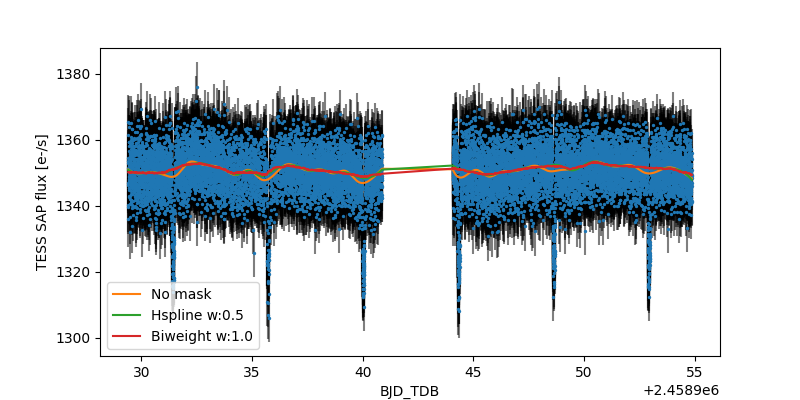

In [22]:
plt.figure(figsize=(8,4))
plt.scatter(time, sap_flux, c='C0', s=2)
plt.errorbar(time, sap_flux, yerr=sap_flux_error, ecolor='k', fmt=' ', alpha=0.5, zorder=-1)
plt.plot(time, sap_flatten_model, c='C1', zorder=10, label='No mask')
plt.plot(time, sap_masked_flatten_model, c='C2', zorder=11, label='Hspline w:0.5')
plt.plot(time, sap_masked_biweight_w10_model, c='C3', zorder=11, label='Biweight w:1.0')
plt.xlabel('BJD_TDB')
plt.ylabel('TESS SAP flux [e-/s]')
plt.legend()
plt.show()

Finally, we save the selected filtered lightcurve and the associated errors for the next analysis step.

**Note:** You must repeat this analysis for every sector. You can use the same filtering algorithm for all the sectors or filter each sector independently from the others. Pay attention to not overwrite the files of different sectors. 

In [27]:
pickle.dump(time, open('TESS_sector23_bjd_tdb.p','wb'))
pickle.dump(sap_masked_flatten_flux, open('TESS_sector23_sap_masked_huberspline.p','wb'))
pickle.dump(sap_flux_error/sap_masked_flatten_model, open('TESS_sector23_sap_masked_huberspline_error.p','wb'))